# Laboratorio de predicción lineal

## Intentaremos aplicar predicción lineal sobre señales de voz.

In [1]:
%pip install wget

In [2]:
%matplotlib notebook

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import wget
import scipy.io.wavfile as wave
import IPython
from scipy.linalg import toeplitz, inv

## Sabiendo que las señales de voz pueden ser modeladas con un modelo autorregresivo:

### 1. Realizar una grabación de duración T = 2 s y fs = 8 kHz de los sonidos /a/ y /sh/.

In [4]:
a_url = 'https://raw.githubusercontent.com/ManuMollon261297/PASA/master/TP3/recordings/a.wav'
a_file = wget.download(a_url)

sh_url = 'https://raw.githubusercontent.com/ManuMollon261297/PASA/master/TP3/recordings/sh.wav'
sh_file = wget.download(sh_url)

In [5]:
fs, a_arr = wave.read(a_file)
# Downsample fs to 8KHz
desired_fs = 8000
final_len = int(len(a_arr) * (8000/fs))
resampled_a = sig.resample(a_arr, final_len)
norm_a = resampled_a/np.amax(resampled_a)

print("fs = "+str(desired_fs))
print("Number of samples = "+ str(len(resampled_a)))
IPython.display.Audio(resampled_a,rate=desired_fs)

fs = 8000
Number of samples = 20640


In [6]:
fs, sh_arr = wave.read(str(sh_file))

# Downsample fs to 8KHz
desired_fs = 8000
final_len = int(len(sh_arr) * (8000/fs))
resampled_sh = sig.resample(sh_arr, final_len)
norm_sh = resampled_sh/np.amax(resampled_sh)

print("fs = "+str(desired_fs))
print("Number of samples = "+ str(len(resampled_sh)))
IPython.display.Audio(resampled_sh,rate=desired_fs)

fs = 8000
Number of samples = 19616


### 2. Para ambos sonidos, realizar la predicción forward con $ N_{o} = 1 $, y representar el error cuadrático medio J en función de M, para valores de M entre 1 y 100.

In [7]:
def autocorreltion(x):
  norm_x = (x - x.mean())/(abs(x).max())
  return np.correlate(norm_x,norm_x,mode='full') / len(x)

def LevinsonDurbin(r,debug = False):
  last_delta = np.conj(r[1])
  a_coefs = 1
  M = len(r)-1
  P_values = []
  P_values.append(r[0])
  for i in range(1,M):
    k = (-last_delta) / P_values[-1]
    last_coefs = a_coefs
    a_coefs = np.ones(i+1, dtype= np.float64)
    a_coefs[-1] = k 
    if (i>1):
      a_coefs[1:-1] = last_coefs[1:] + k*np.flip(np.conj(last_coefs[1:]))
    P_values.append( P_values[-1] * (1- (abs(k)**2) ) )
    last_delta = np.dot(np.flip(r[1:i+2]),a_coefs)
    if debug:
      print("m = "+str(i))
      print("a_coefs:",a_coefs)
      print("p = "+str(P_values[-1]))
      print("k = "+str(k))
      print("delta = ")
      print(last_delta)
  return a_coefs,P_values

In [8]:
def a_sub_k_to_w_sub_k(a_arr):
    return (-np.asarray(a_arr[1:]))

In [9]:
def plot_m_vs_j(ms, js):
    plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
    plt.ylabel('Pm')
    plt.xlabel('M')
    plt.title('J(M)')
    plt.grid('on')
    plt.plot(ms, js)
    plt.show()

In [10]:
# Levinson Durbin Test
M = 5
r = autocorreltion(resampled_a)
r = r[r.argmax():r.argmax()+M]
print("r:",r)
LevinsonDurbin(r,debug = True)

r: [0.02368022 0.02105136 0.01541871 0.0103042  0.00784205]
m = 1
a_coefs: [ 1.         -0.88898508]
p = 0.004965873222952802
k = -0.8889850810340103
delta = 
-0.003295633708181237
m = 2
a_coefs: [ 1.         -1.47896575  0.66365643]
p = 0.0027787047128308034
k = 0.6636564326589052
delta = 
0.001471326918779622
m = 3
a_coefs: [ 1.         -1.83037249  1.44677027 -0.529501  ]
p = 0.0019996356408529662
k = -0.5295009980678044
delta = 
0.00014213280628778968


(array([ 1.        , -1.83037249,  1.44677027, -0.529501  ]),
 [0.023680221140579927,
  0.004965873222952802,
  0.0027787047128308034,
  0.0019996356408529662])

### Forward prediction of 'a' signal with $ N_{o} = 1 $:

In [11]:
def filterW(data, w_o):
    samples = len(data)
    if type(w_o) != int:
        M = len(w_o)
    else:
        M = 1
    filtered = np.zeros(samples)
    filtered = sig.filtfilt(w_o, [1], data)
    return filtered

<IPython.core.display.Javascript object>


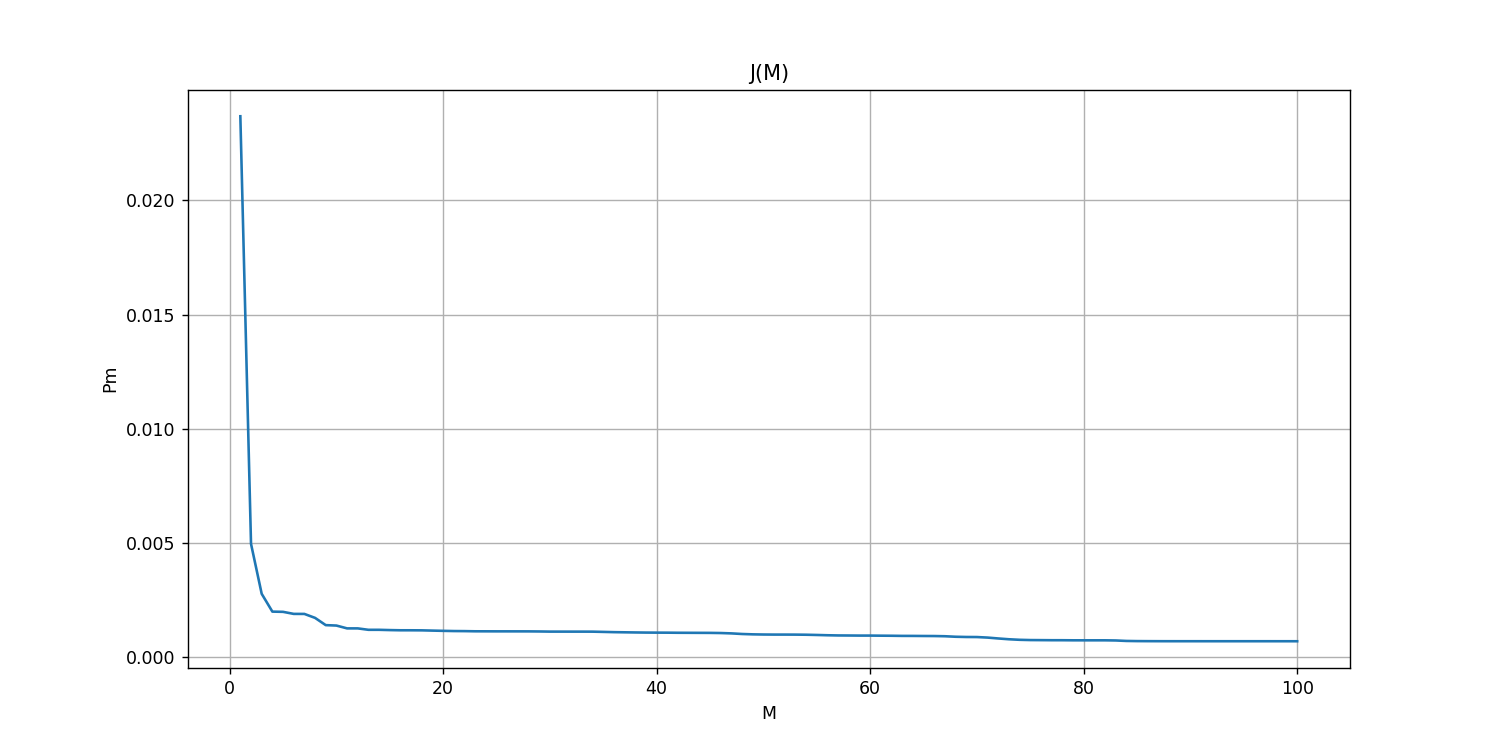

In [12]:
# Representar el error cuadrático medio J en función de M, para valores de M entre 1 y 100.
i = 101
r = autocorreltion(resampled_a)
r = r[r.argmax():r.argmax()+i]
M = len(r)-1
m = np.arange(1,M+1)
_, p_list = LevinsonDurbin(r)
plot_m_vs_j(m, p_list)

### Forward prediction of 'sh' signal with $ N_{o} = 1 $:

<IPython.core.display.Javascript object>


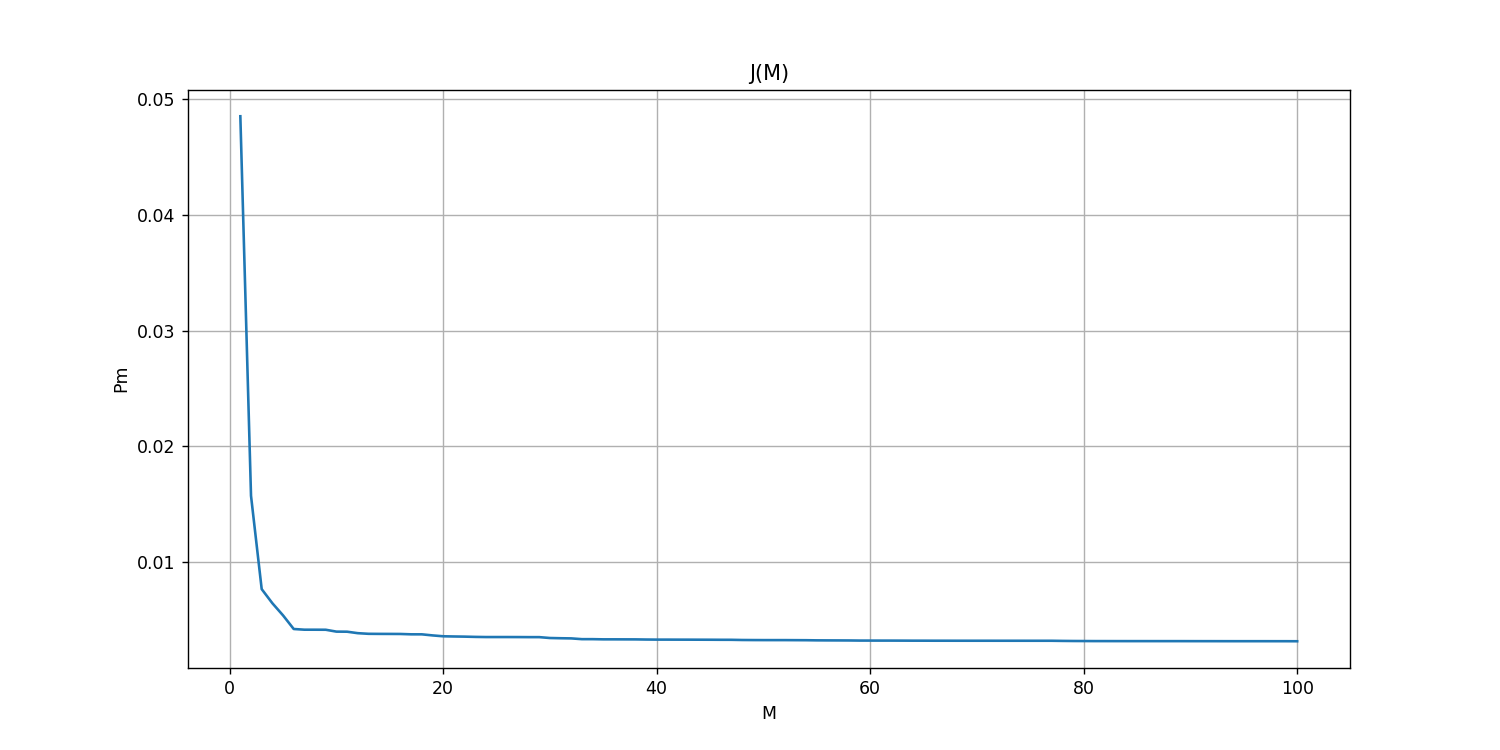

In [13]:
# Representar el error cuadrático medio J en función de M, para valores de M entre 1 y 100.
i = 101
r = autocorreltion(resampled_sh)
r = r[r.argmax():r.argmax()+i]
M = len(r)-1
m = np.arange(1,M+1)
_, p_list = LevinsonDurbin(r)
plot_m_vs_j(m, p_list)

### 3. Para ambos sonidos, analizar cualitativa y cuantitativamente la señal del error de predicción y el espectro $ H(e^{jω}) $ del filtro autorregresivo estimado para M = 1, 6, 12, 24, 100. Comparar este espectro con el espectro obtenido por estimación no-paramétrica.

<IPython.core.display.Javascript object>


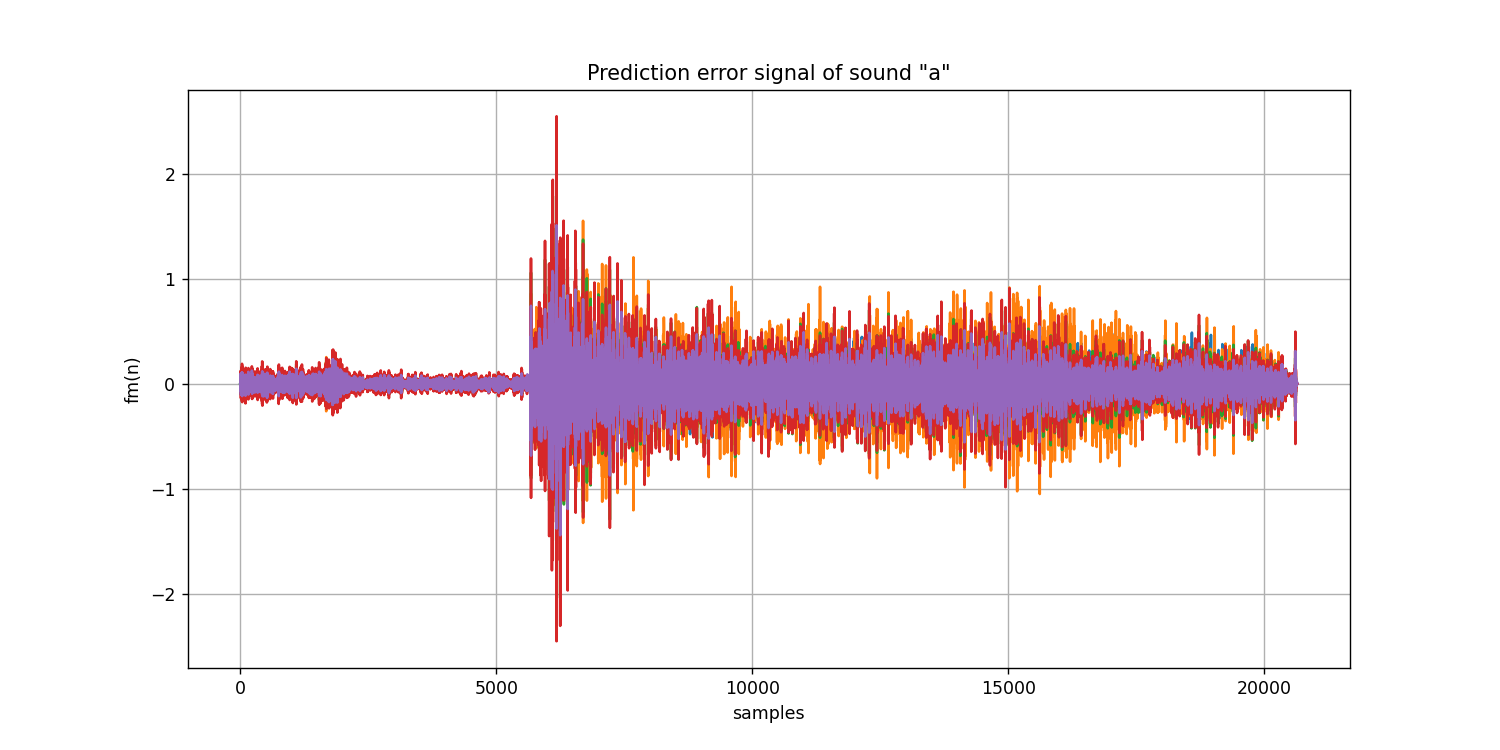

In [14]:
plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('fm(n)')
plt.xlabel('samples')
plt.title('Prediction error signal of sound "a"')
plt.grid('on')

for M in (2, 6, 12, 24, 100):
    i = M+1
    r = autocorreltion(norm_a)
    r = r[r.argmax():r.argmax()+i]
    a_coefs, p_list = LevinsonDurbin(r)
    fm = filterW(norm_a, a_coefs)
    plt.plot(fm)
    #plt.figure('Ha(e^jw)')
    #plt.plot(h)

plt.show()

<IPython.core.display.Javascript object>


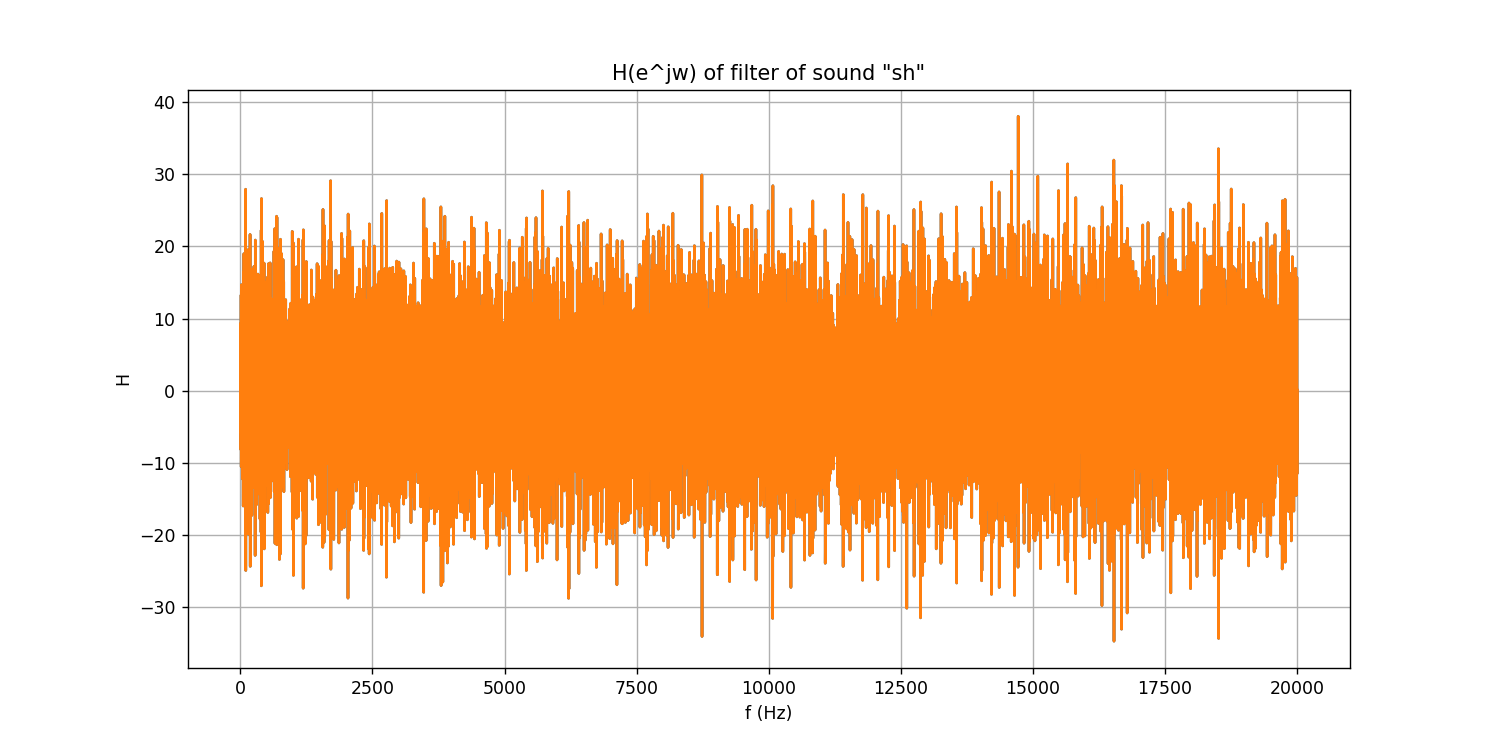

In [15]:
plt.figure(num='Ha(e^jw)', figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('H')
plt.xlabel('f (Hz)')
plt.title('H(e^jw) of filter of sound "a"')
plt.grid('on')

for M in (2, 6, 12, 24, 100):
    i = M+1
    r = autocorreltion(norm_a)
    r = r[r.argmax():r.argmax()+i]
    a_coefs, p_list = LevinsonDurbin(r)
    fm = filterW(norm_a, a_coefs)
    #plt.plot(h)

plt.show()

<IPython.core.display.Javascript object>


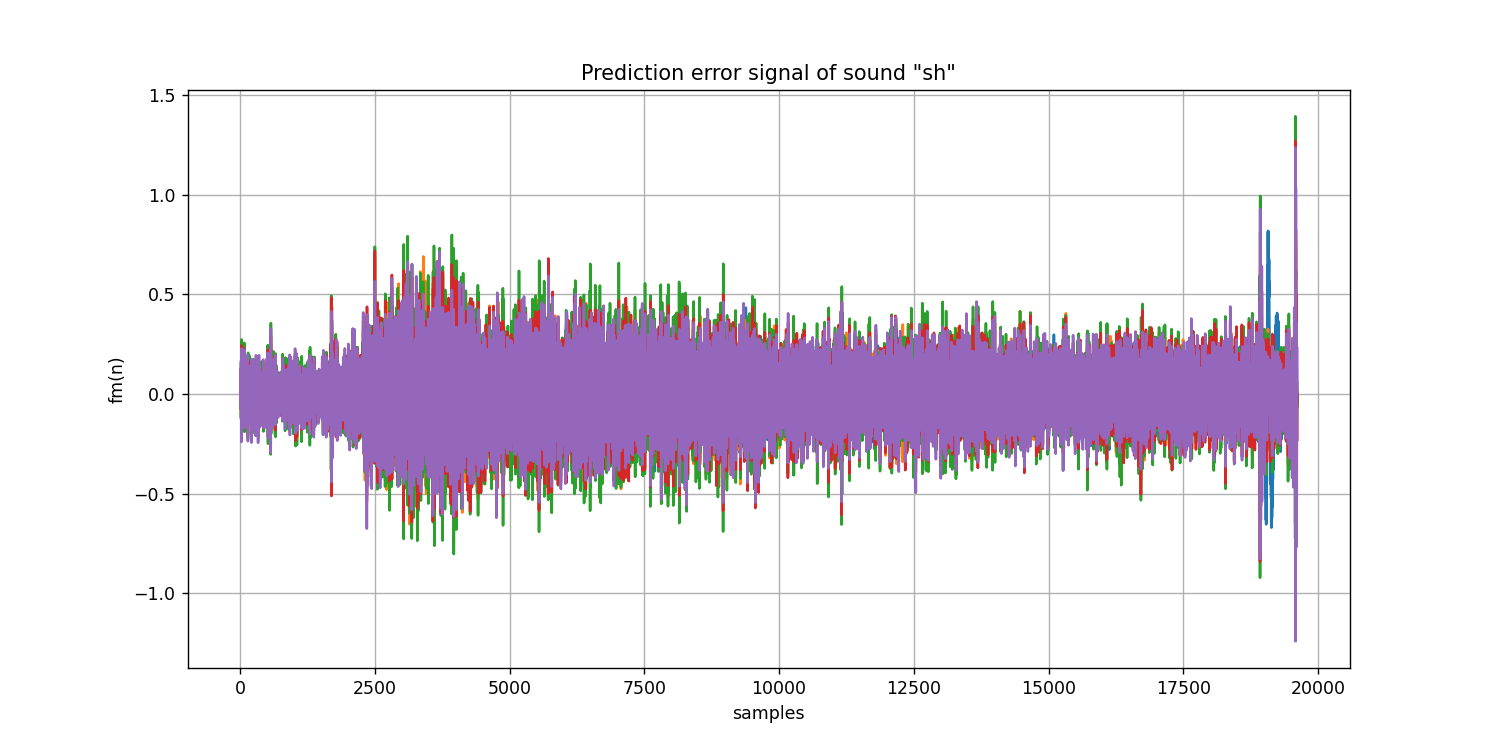

In [16]:
plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('fm(n)')
plt.xlabel('samples')
plt.title('Prediction error signal of sound "sh"')
plt.grid('on')

for M in (2, 6, 12, 24, 100):
    i = M+1
    r = autocorreltion(norm_sh)
    r = r[r.argmax():r.argmax()+i]
    a_coefs, p_list = LevinsonDurbin(r)
    fm = filterW(norm_sh, a_coefs)
    plt.plot(fm)
    #plt.figure('Ha(e^jw)')
    #plt.plot(h)

plt.show()

In [17]:
plt.figure(num='Ha(e^jw)', figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('H')
plt.xlabel('f (Hz)')
plt.title('H(e^jw) of filter of sound "sh"')
plt.grid('on')

for M in (2, 6, 12, 24, 100):
    i = M+1
    r = autocorreltion(norm_sh)
    r = r[r.argmax():r.argmax()+i]
    a_coefs, p_list = LevinsonDurbin(r)
    fm = filterW(norm_a, a_coefs)
    #plt.plot(h)

plt.show()

### 4. ¿Cuál es el orden óptimo Mo para cada sonido?

In [18]:
Mopt = 12

### 5. Sintetizar los sonidos aplicando el filtro autorregresivo estimado de orden Mo a una excitación apropiada.

<IPython.core.display.Javascript object>


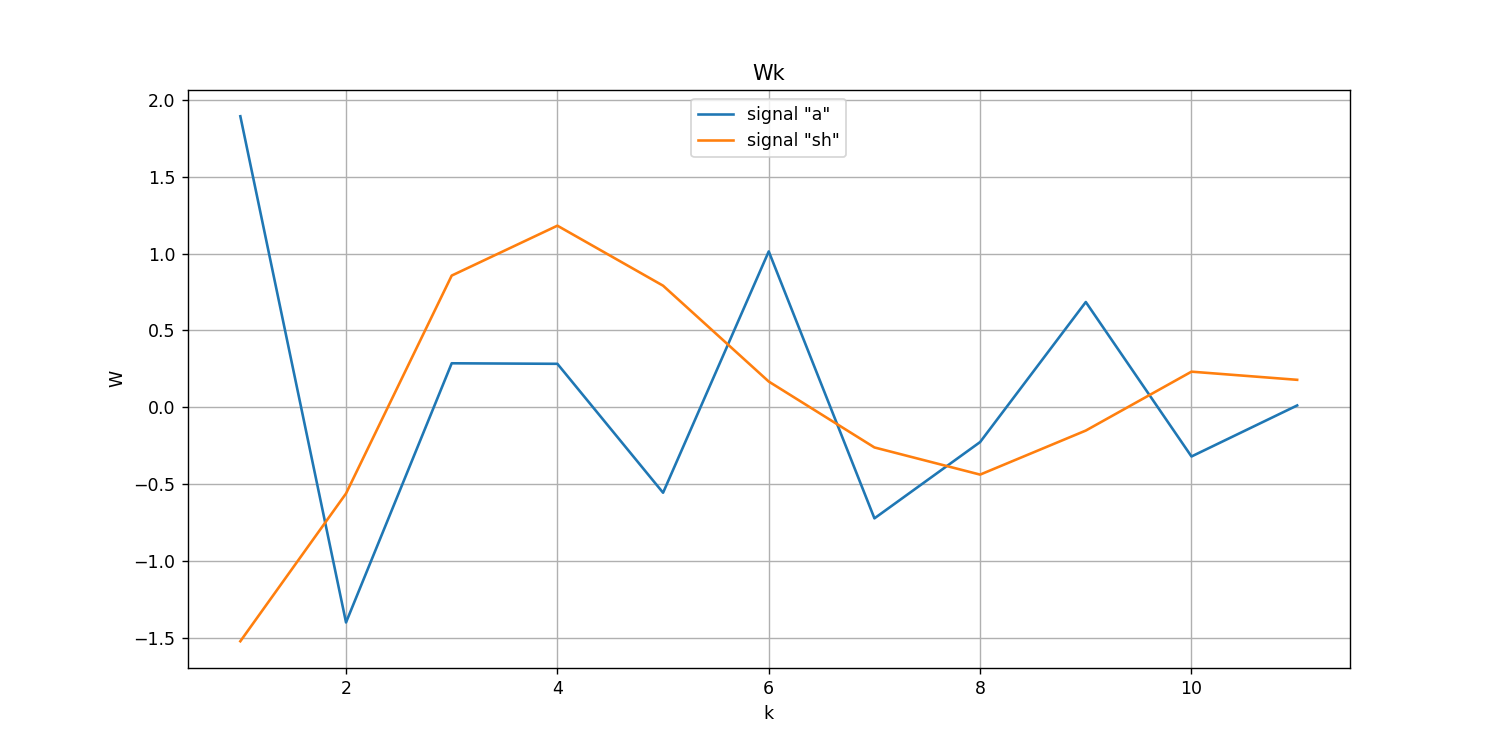

<IPython.core.display.Javascript object>


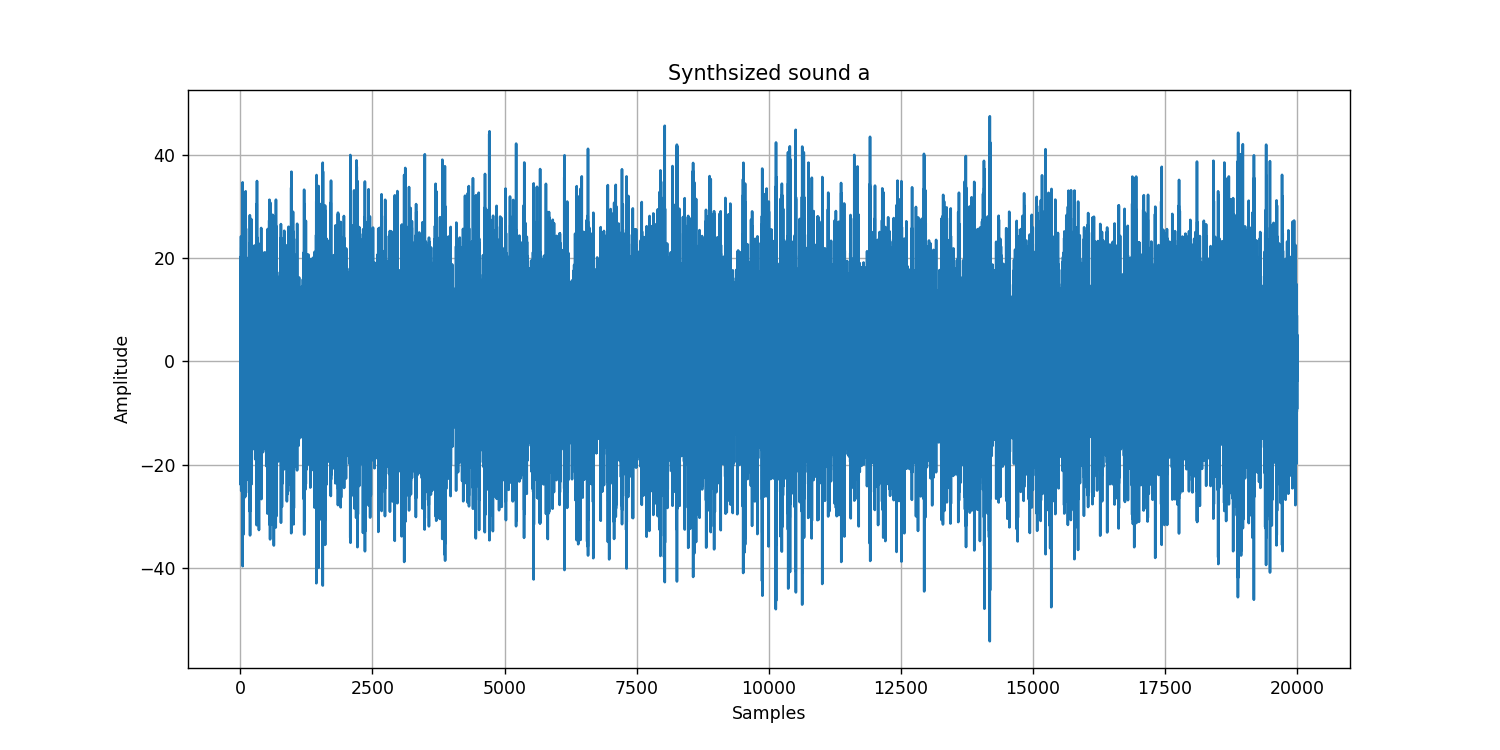

<IPython.core.display.Javascript object>


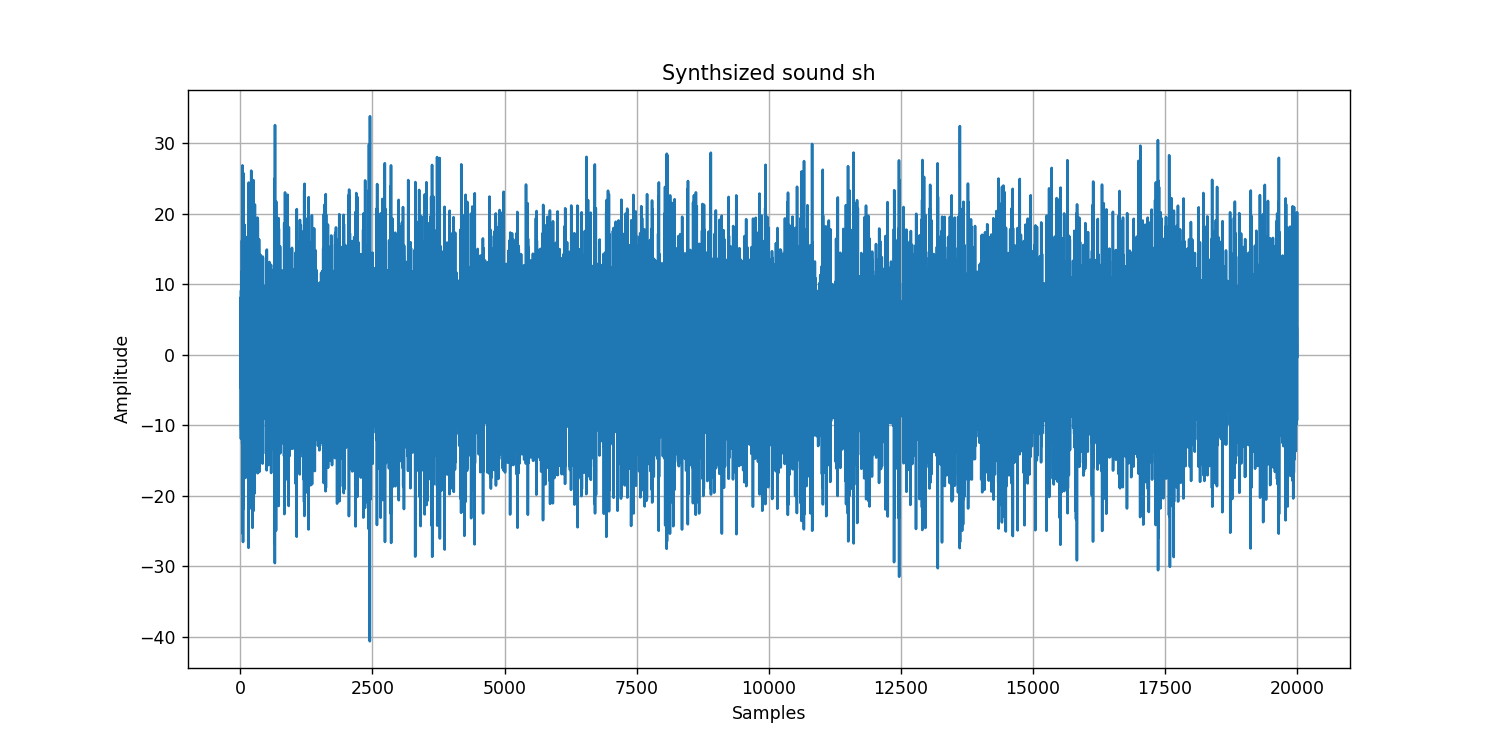

In [30]:
noise = np.random.normal(0,1,20000)

i = Mopt+1
r = autocorreltion(norm_a)
r = r[r.argmax():r.argmax()+i]
a_coefs, p_list = LevinsonDurbin(r)
wk_a = a_sub_k_to_w_sub_k(a_coefs)

i = Mopt+1
r = autocorreltion(norm_sh)
r = r[r.argmax():r.argmax()+i]
a_coefs, p_list = LevinsonDurbin(r)
wk_sh = a_sub_k_to_w_sub_k(a_coefs)

synth_a = filterW(noise, wk_a)
synth_sh = filterW(noise, wk_sh)

plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('W')
plt.xlabel('k')
plt.title('Wk')
plt.grid('on')
plt.plot(np.arange(1,Mopt), wk_a, label='signal "a"')
plt.plot(np.arange(1,Mopt), wk_sh, label='signal "sh"')
plt.legend(loc='upper center')
plt.show()

plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.title('Synthsized sound a')
plt.grid('on')
plt.plot(synth_a)
plt.show()

plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.title('Synthsized sound sh')
plt.grid('on')
plt.plot(synth_sh)
plt.show()

In [26]:
IPython.display.Audio(noise,rate=desired_fs)

In [24]:
IPython.display.Audio(synth_sh,rate=desired_fs)

In [25]:
IPython.display.Audio(synth_a,rate=desired_fs)

### 6. Para el sonido /a/ y con Mo, realizar la recursión de Levinson-Durbin y representar los coeficientes κm en función de m.

<IPython.core.display.Javascript object>


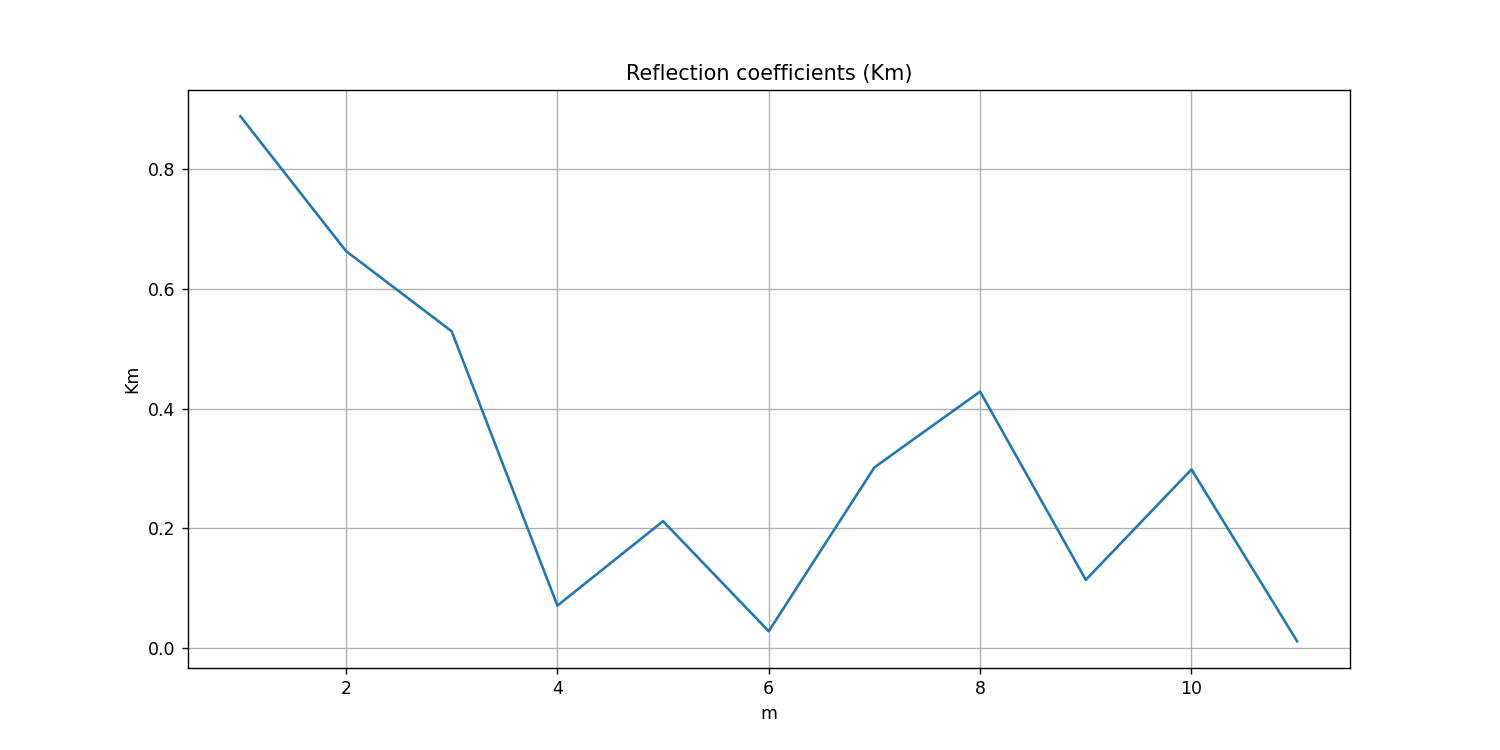

In [35]:
i = Mopt+1
r = autocorreltion(norm_a)
r = r[r.argmax():r.argmax()+i]
_, p_list = LevinsonDurbin(r)
ks = list()

for m in range(1, len(p_list)):
    k_aux = np.sqrt(1-(p_list[m]/p_list[m-1]))
    ks.append(k_aux)


plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('Km')
plt.xlabel('m')
plt.title('Reflection coefficients (Km)')
plt.grid('on')
plt.plot(np.arange(1,len(p_list)), ks)
plt.show()